c:\Users\11730\OneDrive\桌面\420a2\a2dataset\venv\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\11730\OneDrive\桌面\420a2\a2dataset\venv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


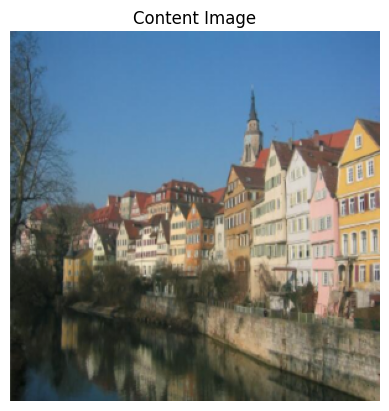

Style Loss: 151.22610473632812
a 0.5381661057472229


In [63]:
import torch
from torchvision import models, transforms
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

# Function to load and preprocess an image
def load_image(image_path, size=299):
    """Load and preprocess an image."""
    image = Image.open(image_path).convert('RGB')
    in_transform = transforms.Compose([
        transforms.Resize((size, size)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    return in_transform(image).unsqueeze(0)

def imshow(tensor, title=None, ax=None, figsize=(5, 5)):
    if ax is None:
        fig, ax = plt.subplots(figsize=figsize)
    image = tensor.cpu().clone().detach().numpy().squeeze()
    image = image.transpose(1, 2, 0)
    image = image * np.array((0.229, 0.224, 0.225)) + np.array((0.485, 0.456, 0.406))
    image = image.clip(0, 1)
    
    ax.imshow(image)
    if title is not None:
        ax.set_title(title)
    ax.axis('off')


# Function to extract features from specified layers of the model
def get_features(image, model, layers):
    """ Extract features from the layers of the model. """
    features = {}
    x = image
    # Access each layer directly by name and ensure compatible operations
    for name, layer in model.named_children():
        if "AuxLogits" in name:  # Skip auxiliary classifier
            continue
        x = layer(x)
        if name in layers:
            features[name] = x
        if name == 'Mixed_7c':  # Last layer you need features from
            break
    return features


# Function to compute the Gram matrix of a feature map
def gram_matrix(tensor):
    """Compute the Gram matrix from an input tensor."""
    _, d, h, w = tensor.size()
    tensor = tensor.view(d, h * w)
    return torch.mm(tensor, tensor.t())

# Setup device and load model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
inception = models.inception_v3(pretrained=True).to(device)
inception.eval()

# Specify layers to extract features from for style representation
style_layers = {
    'Conv2d_1a_3x3': 1.0, 
    'Conv2d_2a_3x3': 1.0,
    'Conv2d_2b_3x3': 1.0,
    'Mixed_5b': 1.0,
    'Mixed_5c': 1.0
}
content_layer = 'Mixed_5c'
style_weights = {key: 1.0 for key in style_layers.values()}

# Load images
content_image = load_image('content2.jpg').to(device)
imshow(content_image, title='Content Image')
style_image = load_image('style2.jpg').to(device)

# Extract features
content_features = get_features(content_image, inception, style_layers.keys())
style_features = get_features(style_image, inception, style_layers.keys())

# Calculate style loss
style_loss = 0
for layer, weight in style_layers.items():
    content_gram = gram_matrix(content_features[layer])
    style_gram = gram_matrix(style_features[layer])
    _, d, h, w = style_features[layer].shape
    layer_loss = torch.mean((content_gram - style_gram) ** 2)
    style_loss += weight * layer_loss / (d * h * w)

print("Style Loss:", style_loss.item())

def content_loss(content_features, target_features):
    return torch.mean((target_features - content_features)**2)

aaaaa = content_loss(content_features[content_layer],style_features[content_layer])
print("a",aaaaa.item())




In [64]:
import torch.optim as optim

# For displaying the target image, intermittently
show_every = 1000
target = content_image.clone().requires_grad_(True).to(device)

# Iteration hyperparameters
optimizer = optim.Adam([target.requires_grad_()], lr=0.02)
steps = 8000  # Decide how many iterations to update your image
content_weight = 1e4
style_weight = 1e6

Iteration: 1 Total loss: 151226112.0


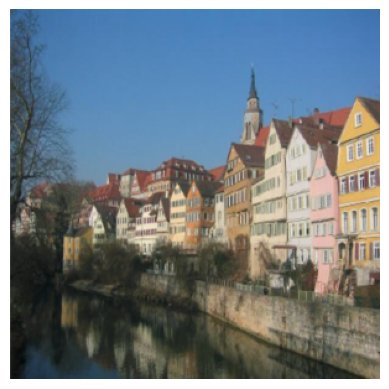

RuntimeError: Trying to backward through the graph a second time (or directly access saved tensors after they have already been freed). Saved intermediate values of the graph are freed when you call .backward() or autograd.grad(). Specify retain_graph=True if you need to backward through the graph a second time or if you need to access saved tensors after calling backward.

In [65]:
for ii in range(1, steps + 1):
    optimizer.zero_grad()  # Clear previous gradients

    target_features = get_features(target, inception, style_layers.keys())
    
    content_loss_val = content_loss(content_features[content_layer], target_features[content_layer])
    
    style_loss_val = 0

    for layer, weight in style_layers.items():
        target_feature = target_features[layer]
        target_gram = gram_matrix(target_feature)
        _, d, h, w = target_feature.shape
        style_gram = gram_matrix(style_features[layer])
        layer_style_loss = weight* torch.mean((target_gram - style_gram)**2)
        style_loss_val += layer_style_loss / (d * h * w)

    total_loss = content_weight * content_loss_val + style_weight * style_loss_val
    
    total_loss.backward()  # Only need to retain graph if multiple backward passes in the same iteration
    optimizer.step()
    
    # Display intermediate images and print the loss
    if ii % show_every == 0 or ii == 1:
        print('Iteration:', ii, 'Total loss:', total_loss.item())
        imshow(target)

        plt.show()
